In [1]:
import sys
sys.path.append("../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
import time

plt.style.use(FIG_ROOT/"base.mplstyle")

In [3]:
from utils.misc import load_txt

In [19]:
import re

def extract_losses(text, is_base=True):
    train_losses = []
    test_losses = []

    for line in text:
        if line.strip() == '':
            continue
        
        tmp = re.search(r'iter (\d+)', line)
        if tmp is not None:
            iter_num = int(re.search(r'iter (\d+)', line).group(1))
            loss = float(re.search(r'the losses are (\d+\.\d+)', line).group(1))
            if is_base:
                loss_base = float(re.search(r'the base losses are (\d+\.\d+)', line).group(1))
            iter_num_perepoch = int(re.search(r'/(\d+),', line).group(1))
            epoch_num = int(re.search(r'epoch (\d+),', line).group(1))
        
            if 'train' in line:
                if is_base:
                    train_losses.append((iter_num + (epoch_num-1)*iter_num_perepoch, loss, loss_base))
                else:
                    train_losses.append((iter_num + (epoch_num-1)*iter_num_perepoch, loss))
            elif 'test' in line:
                if is_base:
                    test_losses.append((iter_num + (epoch_num-1)*iter_num_perepoch, loss, loss_base))
                else:
                    test_losses.append((iter_num + (epoch_num-1)*iter_num_perepoch, loss))

    return np.array(train_losses), np.array(test_losses)

def moving_median(data, window_size):
    if window_size < 1 or not isinstance(window_size, int):
        raise ValueError("Window size must be a positive integer")

    if len(data) < window_size:
        raise ValueError("Window size must be smaller than or equal to the length of the data")

    result = []
    for i in range(len(data) - window_size + 1):
        result.append(np.median(data[i:i + window_size]))
    return np.array(result)

In [20]:
fil_path = RES_ROOT/"../bash_scripts/scs/logs/RUN-base-20204.out"
txt_content = load_txt(fil_path);
txt_content[-10:]

['At iter 1100/8116, epoch 2, the losses are 0.152 (train). the base losses are 0.122 (train). The time used is 22.137s. \n',
 'At iter 1100/8116, epoch 2, the losses are 0.159 (test). the base losses are 0.110 (test). \n',
 'At iter 1102/8116, epoch 2, the losses are 0.156 (train). the base losses are 0.117 (train). The time used is 24.738s. \n',
 'At iter 1104/8116, epoch 2, the losses are 0.149 (train). the base losses are 0.121 (train). The time used is 23.259s. \n',
 'At iter 1106/8116, epoch 2, the losses are 0.146 (train). the base losses are 0.111 (train). The time used is 20.332s. \n',
 'At iter 1108/8116, epoch 2, the losses are 0.151 (train). the base losses are 0.116 (train). The time used is 19.016s. \n',
 'At iter 1110/8116, epoch 2, the losses are 0.150 (train). the base losses are 0.113 (train). The time used is 16.064s. \n',
 'At iter 1112/8116, epoch 2, the losses are 0.154 (train). the base losses are 0.122 (train). The time used is 24.010s. \n',
 'At iter 1114/8116,

In [21]:
tr_losses, te_losses = extract_losses(txt_content, True)
tr_losses.shape

(4616, 3)

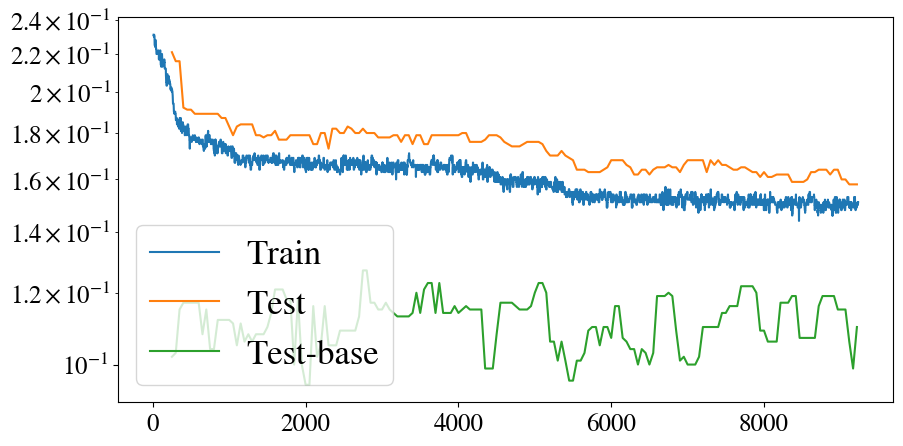

In [22]:
win_size = 5
plt.plot(tr_losses[(win_size-1):, 0], moving_median(tr_losses[:, 1], win_size), label="Train")
plt.plot(te_losses[(win_size-1):, 0], moving_median(te_losses[:, 1], win_size), label="Test")
#plt.plot(tr_losses[(win_size-1):, 0], moving_median(tr_losses[:, 2], win_size), label="Train-base")
plt.plot(te_losses[(win_size-1):, 0], moving_median(te_losses[:, 2], win_size), label="Test-base")
plt.yscale("log")
#plt.ylim([4, 6])
plt.legend()